In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [148]:
ddir = '../data/'
dfo = pd.read_csv(ddir + 'output_1000stars.csv')
dfb = pd.read_csv(ddir + 'output_back.csv')
dfb['ID'] = dfb.kic
dfo = dfo.merge(dfb, on='ID', how='inner')
dfo.head()

,Unnamed: 0_x,ID,Numax,Numax_err,Dnu_median_all,Dnu_median_all_err,Dnu_lin_all,Dnu_lin_all_err,Dnu_median,Dnu_median_err,...,hsig2_err,htau2_err,hexp2_err,hsig3_err,htau3_err,hexp3_err,numax_err,width_err,height_err,white_err
0,0,10907196,42.981248,1.456479,4.643757,0.031838,4.627682,0.009020,4.515881,0.020666,...,146.750245,0.000478,2.088563,10161.966598,0.174502,1.122698,0.301250,0.562144,0.043236,0.210266
1,1,10962775,34.176654,1.342026,4.170277,0.025856,4.175639,0.008983,4.109381,0.053946,...,319.727642,0.000745,2.111479,13953.309013,0.392435,1.191992,0.272407,0.484415,0.049086,0.229338
2,2,11177749,33.498019,0.049846,3.994627,0.034499,4.043383,0.005263,3.992557,0.036054,...,408.109322,0.001086,2.404805,13778.289503,0.253747,1.227881,0.276012,0.519144,0.044759,0.287902
3,3,11231549,28.981327,0.348002,3.420870,0.024150,3.420275,0.008271,3.409848,0.022164,...,582.960198,0.000939,1.877270,15889.250035,0.404265,1.079931,0.235468,0.415594,0.057141,0.257877
4,4,11178396,27.302513,1.358871,3.935907,0.032983,3.921243,0.011144,3.954535,0.038207,...,313.216553,0.000891,1.953115,10409.351636,0.081276,1.110590,0.302413,0.464244,0.044895,0.556517


In [150]:
dfo = dfo.loc[np.abs(dfo.numax - 100) < 50.0]
dfo = dfo[:10]
print(len(dfo))

10


In [151]:
dfs = [pd.read_csv(ddir + 'rgbmodes/' + 'modes_' + str(n) + '.csv') for n in dfo.ID.values]

In [152]:
dfs[0].head()

,f0,A0,w0,f2,A2,w2,B,f0_err,A0_err,w0_err,f2_err,A2_err,w2_err,B_err
0,67.134181,0.314992,-1.638969,66.156191,-0.296279,-1.428363,0.984344,0.023925,0.099470,0.261110,0.056861,0.933902,0.400805,0.147090
1,73.876354,0.557711,-2.420970,72.984213,0.087236,-1.462705,0.875186,0.011801,0.118616,0.313124,0.013195,0.110587,0.222226,0.091258
2,80.465439,0.543752,-1.611542,79.489703,0.208019,-1.296095,1.109564,0.022540,0.093484,0.280062,0.041132,0.256675,0.278387,0.156919
3,87.112566,0.416559,-1.492739,86.152926,0.226505,-1.392699,0.974907,0.026584,0.102978,0.237438,0.081645,0.351563,0.435444,0.160393
4,93.909854,0.172453,-1.519738,92.895309,-0.171237,-1.426687,1.096748,0.030708,0.110007,0.269627,0.158828,1.370379,0.724516,0.141596


In [153]:
ns = np.zeros([len(dfs), 30])
f0s = np.zeros([len(dfs), 30])
f0s_err = np.ones([len(dfs), 30])*1e6
for idx, df in enumerate(dfs):
    df = df.sort_values(by=['f0'])
    n = np.floor(df.f0 / np.median(np.diff(np.sort(df.f0.values))))
    index = int(n[0])
    ns[idx, index:index+len(df)] = n
    f0s[idx, index:index+len(df)] = df.f0.values
    f0s_err[idx, index:index+len(df)] = df.f0_err.values

(0, 288)

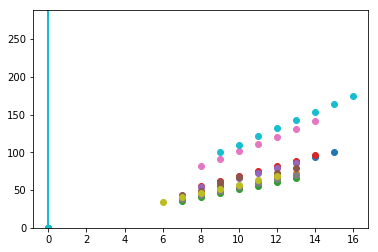

In [154]:
fig, ax = plt.subplots()
for i in range(len(dfs)):
    ax.errorbar(ns[i, :], f0s[i,:], yerr=f0s_err[i,:], linestyle='none', marker='o')
ax.set_ylim([0, 288])

In [165]:
code = '''
functions {
    real asy(real n, real dnu, real eps, real numax, real alpha){
        return (n + eps + alpha / 2 * (n - (numax / dnu - eps))^2) * dnu;
    }
}
data {
    int N; // Number of stars
    int M; // Number of orders
    real n[N, M];
    real f[N,M];
    real ferr[N,M];
    real numax_obs[N];
    real numax_err[N];
}
parameters {
    real dnu[N];
    real epsilon_std[N];
    real<lower=0> numax[N];
    real<lower = 0, upper = 0.2> alpha;
    real<lower=0> eps_std;
    real alpha_eps;
    real beta_eps;
}
transformed parameters {
    real epsilon[N];
    for (i in 1:N){
        epsilon[i] = epsilon_std[i] * eps_std + (alpha_eps + beta_eps * log(dnu[i]));
    }
}
model {
    real tmp[M];
    for (i in 1:N){
        for (j in 1:M)
            tmp[j] = asy(n[i,j], dnu[i], epsilon[i], numax[i], alpha);
        f[i,:] ~ normal(tmp, ferr[i, :]); 
    }
    epsilon_std ~ normal(0, 1);
    dnu ~ uniform(0, 20);
    numax ~ normal(numax_obs, numax_err);
    alpha ~ normal(0.008, 0.01);
    eps_std ~ normal(0, 0.5);
    alpha_eps ~ normal(0.601, 0.25);
    beta_eps ~ normal(0.632, 0.25);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08f7cf33210b1d625a21b42c4acdf55a NOW.


In [171]:
nchains = 4
data = {'N': len(dfs),
        'M': ns.shape[1],
        'n' : ns,
        'f' : f0s,
        'ferr': f0s_err,
        'numax_obs': dfo.numax.values,
        'numax_err': dfo.numax_err.values}
start = {'dnu': dfo.Dnu_lin_all.values,
         'eps_std': 0.01,
         'numax': dfo.numax.values,
         'alpha': 0.008,
         'alpha_eps': 0.601,
         'beta_eps': 0.632}
fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


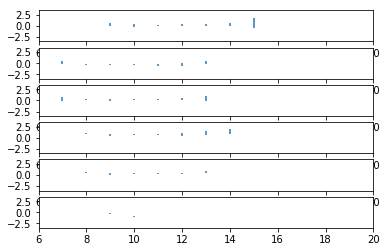

In [176]:
def model(n, dnu, epsilon, numax, alpha):
    nmax = numax / dnu - epsilon
    return (n + epsilon + alpha / 2 * (n - nmax)**2) * dnu

npl = 6
fig, ax = plt.subplots(npl)
for i in range(npl):
    #ax[i].scatter(ns[i, :], f0s[i, :])
    m = model(ns[i, :], fit['dnu'].mean(axis=0)[i], fit['epsilon'].mean(), 
              fit['numax'].mean(axis=0)[i], fit['alpha'].mean())
    ax[i].errorbar(ns[i, :], f0s[i,:] - m, yerr=f0s_err[i, :]*10, linestyle='none')
    ax[i].set_xlim([6,20])
    ax[i].set_ylim([-3.5, 3.5])

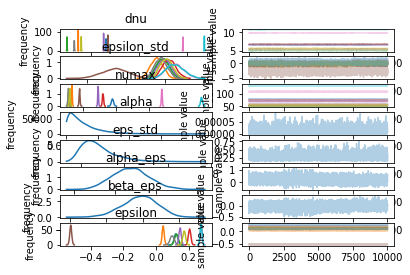

In [173]:
fit.plot()
plt.show()

In [174]:
print(fit)

Inference for Stan model: anon_model_08f7cf33210b1d625a21b42c4acdf55a.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[0]           6.64  2.3e-4 6.3e-3   6.63   6.64   6.64   6.65   6.65    712   1.01
dnu[1]           5.48  1.3e-4 3.8e-3   5.48   5.48   5.48   5.49   5.49    824   1.01
dnu[2]           5.02  2.1e-4 5.6e-3   5.01   5.01   5.02   5.02   5.03    673    1.0
dnu[3]           6.72  1.8e-4 5.1e-3   6.71   6.72   6.72   6.72   6.73    825    1.0
dnu[4]           6.54  1.7e-4 4.4e-3   6.53   6.54   6.54   6.54   6.55    693    1.0
dnu[5]           6.72  1.8e-4 5.1e-3   6.71   6.72   6.72   6.72   6.73    813   1.01
dnu[6]           9.84  2.1e-4 5.5e-3   9.83   9.83   9.84   9.84   9.85    711    1.0
dnu[7]           5.32  3.1e-4 7.3e-3   5.31   5.31   5.32   5.32   5.33    552    1.0
dnu[8]           5.61  2.1e-4 5.5e-3